# Investigation of The Washington Post's Police Killing 2015-20 Dataset

### (Analysis by Will Owusu)

In the wake of the recent murder of George Floyd; by a member of the Minneapolis Police Department, attention surrounding police brutality is at an all time high. 

In this investigation I am going to investigate trends over the last few years and provide a statistical and visual analysis of the killings committed by police.

It is worth noting that any correllation or disproportional representation found in this analysis is not indicative of discrimination by the police. This report intends to identify the trends rather than explain them.

For this report I have analysed the data collected by The Washington Post on fatal police shootings. I have also pulled in US census data by state to be used for state by state analysis at a later date.


### Key Questions:

 - Which racial group are more likely to be killed by police?
 - Which gender is more likely to be killed by police?
 - Do the police kill minors and pensioners?
 - How does the rate of unarmed killings change with demographic?
 - Is one type of group more likely to be deemed mentally ill?

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score
from sklearn.model_selection import train_test_split
np.random.seed(42)
base_color = sns.color_palette()[0]

### Gathering Data

In [2]:
# https://github.com/washingtonpost/data-police-shootings
df = pd.read_csv('https://raw.githubusercontent.com/washingtonpost/data-police-shootings/master/fatal-police-shootings-data.csv')

In [3]:
# https://worldpopulationreview.com/states/states-by-race/
df_state = pd.read_csv(r'C:\Users\willo\Documents\Udactiy Nano-degree\Data Scientist\Project 1 - Police\state-population-by-race.csv')

### Assessing Data

In [4]:
df_state.shape

(51, 8)

In [5]:
df.shape

(5407, 14)

In [6]:
df.columns

Index(['id', 'name', 'date', 'manner_of_death', 'armed', 'age', 'gender',
       'race', 'city', 'state', 'signs_of_mental_illness', 'threat_level',
       'flee', 'body_camera'],
      dtype='object')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5407 entries, 0 to 5406
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       5407 non-null   int64  
 1   name                     5407 non-null   object 
 2   date                     5407 non-null   object 
 3   manner_of_death          5407 non-null   object 
 4   armed                    5180 non-null   object 
 5   age                      5170 non-null   float64
 6   gender                   5405 non-null   object 
 7   race                     4884 non-null   object 
 8   city                     5407 non-null   object 
 9   state                    5407 non-null   object 
 10  signs_of_mental_illness  5407 non-null   bool   
 11  threat_level             5407 non-null   object 
 12  flee                     5158 non-null   object 
 13  body_camera              5407 non-null   bool   
dtypes: bool(2), float64(1), 

There are a few cases of null values, however these should not greatly impact the analysis. In general these values will be ignored when drawing comparisons between groups. 

It is also worth changing datatypes where appropriate such as the Date from object to datetime. 

In [8]:
df_state.head()

,State,WhitePerc,BlackPerc,NativePerc,AsianPerc,IslanderPerc,OtherRacePerc,TwoOrMoreRacesPerc
0,Alabama,0.6819,0.2658,0.0053,0.0133,0.0004,0.0144,0.0188
1,Alaska,0.6484,0.0327,0.1444,0.0630,0.0120,0.0149,0.0846
2,Arizona,0.7722,0.0439,0.0446,0.0329,0.0020,0.0679,0.0364
3,Arkansas,0.7700,0.1541,0.0067,0.0147,0.0027,0.0264,0.0254
4,California,0.6010,0.0579,0.0076,0.1432,0.0039,0.1383,0.0481


In [9]:
df.query('armed == "unarmed"')

,id,name,date,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,threat_level,flee,body_camera
2,5,John Paul Quintero,2015-01-03,shot and Tasered,unarmed,23.0,M,H,Wichita,KS,False,other,Not fleeing,False
8,16,Autumn Steele,2015-01-06,shot,unarmed,34.0,F,W,Burlington,IA,False,other,Not fleeing,True
17,36,Artago Damon Howard,2015-01-08,shot,unarmed,36.0,M,B,Strong,AR,False,attack,Not fleeing,False
62,352,Joshua Omar Garcia,2015-01-26,shot,unarmed,24.0,M,H,Tahoka,TX,False,other,Car,False
71,342,Ralph Willis,2015-01-29,shot,unarmed,42.0,M,W,Stillwater,OK,False,other,Foot,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5258,5751,Michael Ramos,2020-04-24,shot,unarmed,42.0,M,H,Austin,TX,False,undetermined,Car,False
5276,5777,Nicholas Bils,2020-05-01,shot,unarmed,36.0,M,W,San Diego,CA,True,other,Foot,False
5277,5778,Shaun Lee Fuhr,2020-05-01,shot,unarmed,24.0,M,B,Seattle,WA,False,attack,Foot,True
5339,5824,Tyler Hays,2020-05-19,shot,unarmed,29.0,M,W,Sale Creek,TN,False,attack,Not fleeing,False


In [10]:
df['date'] = pd.to_datetime(df['date'])
df['year'] = pd.DatetimeIndex(df['date']).year

In [11]:
df.query('year == 2020')

,id,name,date,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,threat_level,flee,body_camera,year
4936,5403,Gerardo Antonio Conchas-Bustas,2020-01-01,shot,knife,20.0,M,O,Denver,CO,False,attack,Not fleeing,True,2020
4937,5342,Gabriel Strickland,2020-01-01,shot and Tasered,toy weapon,25.0,M,W,Grass Valley,CA,True,attack,Not fleeing,False,2020
4938,5344,Derrick A. Elseth,2020-01-01,shot,gun,24.0,M,W,Richmond County,VA,False,other,Not fleeing,False,2020
4939,5347,Teddy James Maverick Varner,2020-01-01,shot,gun,29.0,M,NaN,Central Point,OR,True,attack,Not fleeing,True,2020
4940,5405,Mariano Ocon,2020-01-02,shot,gun,31.0,M,H,Chicago,IL,False,attack,Foot,False,2020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5402,5911,Lewis Ruffin,2020-06-09,shot,gun,38.0,M,B,Orlando,FL,False,attack,NaN,False,2020
5403,5912,Jerry Bethel,2020-06-10,shot,gun,59.0,M,NaN,Weippe,ID,False,attack,NaN,False,2020
5404,5913,Gregorio Cruz Vanloo,2020-06-11,shot,gun,28.0,M,W,DeKalb County,TN,False,attack,Other,False,2020
5405,5914,Mason James Lira,2020-06-11,shot,gun,26.0,M,W,Paso Robles,CA,True,attack,Not fleeing,False,2020


In [12]:
df.groupby('year').count()

,id,name,date,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,threat_level,flee,body_camera
year,,,,,,,,,,,,,,
2015,994,994,994,994,938,983,994,965,994,994,994,994,985,994
2016,962,962,962,962,899,937,962,904,962,962,962,962,945,962
2017,986,986,986,986,903,953,985,906,986,986,986,986,935,986
2018,991,991,991,991,966,929,991,888,991,991,991,991,939,991
2019,1003,1003,1003,1003,1003,934,1003,859,1003,1003,1003,1003,928,1003
2020,471,471,471,471,471,434,470,362,471,471,471,471,426,471


In [13]:
df_state.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   State               51 non-null     object 
 1   WhitePerc           51 non-null     float64
 2   BlackPerc           51 non-null     float64
 3   NativePerc          51 non-null     float64
 4   AsianPerc           51 non-null     float64
 5   IslanderPerc        51 non-null     float64
 6   OtherRacePerc       51 non-null     float64
 7   TwoOrMoreRacesPerc  51 non-null     float64
dtypes: float64(7), object(1)
memory usage: 3.3+ KB


In [14]:
np.sum(df.duplicated())

0

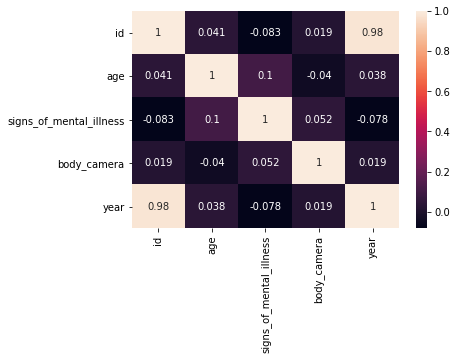

In [15]:
sns.heatmap(df.corr(), annot = True)

No variables show significant correlation at first glance. 

In [16]:
df.threat_level.value_counts()

attack          3490
other           1678
undetermined     239
Name: threat_level, dtype: int64

In [17]:
us_state_abbrev = {'Alabama': 'AL', 'Alaska': 'AK', 'American Samoa': 'AS', 'Arizona': 'AZ', 'Arkansas': 'AR',\
                   'California': 'CA', 'Colorado': 'CO', 'Connecticut': 'CT', 'Delaware': 'DE', \
                   'District of Columbia': 'DC', 'Florida': 'FL', 'Georgia': 'GA', 'Guam': 'GU', 'Hawaii': 'HI',\
                   'Idaho': 'ID', 'Illinois': 'IL', 'Indiana': 'IN', 'Iowa': 'IA', 'Kansas': 'KS', 'Kentucky': 'KY',\
                   'Louisiana': 'LA', 'Maine': 'ME', 'Maryland': 'MD', 'Massachusetts': 'MA', 'Michigan': 'MI', \
                   'Minnesota': 'MN', 'Mississippi': 'MS', 'Missouri': 'MO', 'Montana': 'MT', 'Nebraska': 'NE', \
                   'Nevada': 'NV', 'New Hampshire': 'NH', 'New Jersey': 'NJ', 'New Mexico': 'NM', 'New York': 'NY',\
                   'North Carolina': 'NC', 'North Dakota': 'ND', 'Northern Mariana Islands':'MP', 'Ohio': 'OH',\
                   'Oklahoma': 'OK', 'Oregon': 'OR', 'Pennsylvania': 'PA', 'Puerto Rico': 'PR', 'Rhode Island': 'RI',\
                   'South Carolina': 'SC', 'South Dakota': 'SD', 'Tennessee': 'TN', 'Texas': 'TX', 'Utah': 'UT',\
                   'Vermont': 'VT', 'Virgin Islands': 'VI', 'Virginia': 'VA', 'Washington': 'WA', 'West Virginia': 'WV',\
                   'Wisconsin': 'WI', 'Wyoming': 'WY'}

df_state['State'].replace(us_state_abbrev, inplace = True)

In [18]:
df_state.head()

,State,WhitePerc,BlackPerc,NativePerc,AsianPerc,IslanderPerc,OtherRacePerc,TwoOrMoreRacesPerc
0,AL,0.6819,0.2658,0.0053,0.0133,0.0004,0.0144,0.0188
1,AK,0.6484,0.0327,0.1444,0.0630,0.0120,0.0149,0.0846
2,AZ,0.7722,0.0439,0.0446,0.0329,0.0020,0.0679,0.0364
3,AR,0.7700,0.1541,0.0067,0.0147,0.0027,0.0264,0.0254
4,CA,0.6010,0.0579,0.0076,0.1432,0.0039,0.1383,0.0481


In [19]:
df.race.value_counts()

W    2471
B    1294
H     900
A      93
N      78
O      48
Name: race, dtype: int64

In [20]:
race_dict = {'W': 'White', 'B': 'Black', 'A': 'Asian', 'N': 'Native American', 'H': 'Hispanic', 'O': 'Other', \
             'None': 'unknown'}
df.race.replace(race_dict, inplace = True)

In [21]:
# compares % shot that are black with black proportion in the population
df.query('race == "Black" and state == "AL"').shape[0]/df.query('state == "AL"').\
shape[0], df_state.query('State == "AL"')['BlackPerc']

(0.2980769230769231,
 0    0.2658
 Name: BlackPerc, dtype: float64)

In [22]:
df.head()



,id,name,date,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,threat_level,flee,body_camera,year
0,3,Tim Elliot,2015-01-02,shot,gun,53.0,M,Asian,Shelton,WA,True,attack,Not fleeing,False,2015
1,4,Lewis Lee Lembke,2015-01-02,shot,gun,47.0,M,White,Aloha,OR,False,attack,Not fleeing,False,2015
2,5,John Paul Quintero,2015-01-03,shot and Tasered,unarmed,23.0,M,Hispanic,Wichita,KS,False,other,Not fleeing,False,2015
3,8,Matthew Hoffman,2015-01-04,shot,toy weapon,32.0,M,White,San Francisco,CA,True,attack,Not fleeing,False,2015
4,9,Michael Rodriguez,2015-01-04,shot,nail gun,39.0,M,Hispanic,Evans,CO,False,attack,Not fleeing,False,2015


In [23]:
df_dum = df.copy()

In [24]:
# dummies for race
df_dum[['Asian', 'Black', 'Hispanic', 'Native American', 'Other', 'White']] = pd.get_dummies(df_dum['race'])
# dummies for gender
df_dum[['Female', 'Male']] = pd.get_dummies(df_dum['gender'])
# dummies for mental illness
mental_ill = pd.get_dummies(df_dum['signs_of_mental_illness'])
df_dum['mentally_ill'] = mental_ill[True]
# dummies for body cam
body_cam = pd.get_dummies(df_dum['body_camera'])
df_dum['body_cam'] = body_cam[True]
# dummies fo fleeing
flee = pd.get_dummies(df_dum.flee)
flee['Fleeing'] = (flee['Not fleeing'] * -1) + 1
df_dum['Fleeing'] = flee['Fleeing']

In [25]:
df_dum.threat_level.value_counts()

attack          3490
other           1678
undetermined     239
Name: threat_level, dtype: int64

In [26]:
df_dum.head()

,id,name,date,manner_of_death,armed,age,gender,race,city,state,...,Black,Hispanic,Native American,Other,White,Female,Male,mentally_ill,body_cam,Fleeing
0,3,Tim Elliot,2015-01-02,shot,gun,53.0,M,Asian,Shelton,WA,...,0,0,0,0,0,0,1,1,0,0
1,4,Lewis Lee Lembke,2015-01-02,shot,gun,47.0,M,White,Aloha,OR,...,0,0,0,0,1,0,1,0,0,0
2,5,John Paul Quintero,2015-01-03,shot and Tasered,unarmed,23.0,M,Hispanic,Wichita,KS,...,0,1,0,0,0,0,1,0,0,0
3,8,Matthew Hoffman,2015-01-04,shot,toy weapon,32.0,M,White,San Francisco,CA,...,0,0,0,0,1,0,1,1,0,0
4,9,Michael Rodriguez,2015-01-04,shot,nail gun,39.0,M,Hispanic,Evans,CO,...,0,1,0,0,0,0,1,0,0,0


In [27]:
# df_dum.drop(['gender', 'race', 'body_camera', 'signs_of_mental_illness'], axis = 1)

## What age group are dying at the hands of police?

As can be seen from below, in 2015 and 2017, the youngest victims were white males, shot by police at the age of **six years old**. The oldest of the deceased was 91. The median age is 35, and 50% of the deceased were between 27 and 46 years old.

In [28]:
df.describe()['age'],

(count    5170.000000
 mean       37.132882
 std        13.124091
 min         6.000000
 25%        27.000000
 50%        35.000000
 75%        46.000000
 max        91.000000
 Name: age, dtype: float64,)

In [29]:
df.query('age < 15')

,id,name,date,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,threat_level,flee,body_camera,year
833,980,Jeremy Mardis,2015-11-03,shot,unarmed,6.0,M,White,Marksville,LA,False,other,Car,True,2015
1017,1165,Ciara Meyer,2016-01-11,shot,unarmed,12.0,F,White,Penn Township,PA,False,other,Not fleeing,False,2016
1588,1776,Jesse James Romero,2016-08-09,shot,gun,14.0,M,Hispanic,Los Angeles,CA,False,attack,Foot,True,2016
1681,1883,Tyre King,2016-09-14,shot,toy weapon,13.0,M,Black,Columbus,OH,False,other,Foot,False,2016
2805,3117,Jason Ike Pero,2017-11-08,shot,knife,14.0,M,Native American,Odanah,WI,False,other,Not fleeing,False,2017
2908,3229,Kameron Prescott,2017-12-21,shot,unarmed,6.0,M,White,Schertz,TX,False,other,Not fleeing,False,2017
3985,4386,Antonio Arce,2019-01-15,shot,toy weapon,14.0,M,Hispanic,Tempe,AZ,False,other,Foot,True,2019


In [30]:
df.query('age < 18').shape[0]

98

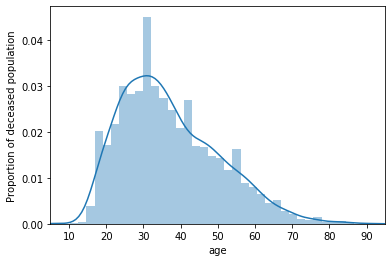

In [31]:
sns.distplot(df['age'])
plt.ylabel('Proportion of deceased population')
plt.xlim(5,95);

## Racial factors on fatal police shootings

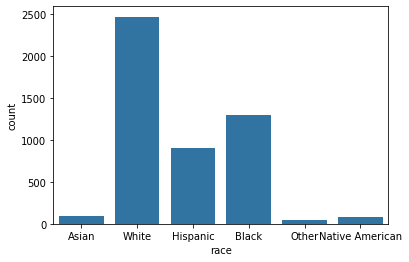

In [32]:
sns.countplot(data = df, x = 'race', color = base_color);
# plt.title('Number of police shooting fatalities 2015 - June 2020', size = 15);

Looking at killings by count, we can see that far more white people are killed by police than any other racial demographic. This, however, is misleading as whites represent a significant amount of the population. Further manipulation is going to be required in order to assess the data on a proportional basis. 

In [33]:
df_dum.Black.sum()

1294

In [34]:
# get a list of the total deaths by race
race = ['White','Black','Asian','Native American','Hispanic','Other']
race_list = []
for i in race:
    total = df_dum[i].sum()
    race_list.append(total)
race_list

[2471, 1294, 93, 78, 900, 48]

In [35]:
# get a list of the total unarmed deaths by race
unarmed_race_list = []
for i in race:
    unarmed_tot = df_dum.query('armed == "unarmed"')[i].sum()
    unarmed_race_list.append(unarmed_tot)

unarmed_race_list

[145, 123, 7, 4, 63, 5]

In [36]:
# convert the death toll into a dataframe
death_toll = pd.DataFrame(dict(zip(race, race_list)), index = ['death_toll'])
death_toll

,White,Black,Asian,Native American,Hispanic,Other
death_toll,2471,1294,93,78,900,48


In [37]:
(2471)/(2471+1294+900+78+48+93), (1294)/(2471+1294+900+78+48+93), 900/(2471+1294+900+78+48+93)

(0.5059377559377559, 0.26494676494676495, 0.18427518427518427)

In [38]:
# convert the unarmed death toll into a dataframe
unarmed_deaths = pd.DataFrame(dict(zip(race, unarmed_race_list)), index = ['unarmed_deaths'])
unarmed_deaths = unarmed_deaths.transpose().reset_index()

In [39]:
unarmed_deaths = unarmed_deaths.rename({'index': 'race'})
unarmed_deaths

,index,unarmed_deaths
0,White,145
1,Black,123
2,Asian,7
3,Native American,4
4,Hispanic,63
5,Other,5


In [40]:
# race proportions per US 2019 census: https://www.census.gov/quickfacts/fact/table/US/PST045219
race_dict = {'White': 60.4, 'Hispanic': 18.3, 'Black': 13.4, 'Asian': 5.9, 'Native American': 1.3, 'Other': 0.2, \
             'Two or more races': 2.7}

df_race = pd.DataFrame(race_dict, index = ['general popuation'])
df_race 

,White,Hispanic,Black,Asian,Native American,Other,Two or more races
general popuation,60.4,18.3,13.4,5.9,1.3,0.2,2.7


In [41]:
df_race.drop(['Two or more races'], axis = 1, inplace = True)

In [42]:
df_race = df_race.merge(death_toll, how = 'outer')

C:\Users\willo\anaconda3\lib\site-packages\pandas\core\reshape\merge.py:1097: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,


In [43]:
# transpose matrix 
df_race = df_race.transpose()
df_race.reset_index(inplace = True)
df_race = df_race.rename(columns = {0: 'population_pct', 1: 'deaths', 'index': 'race'})

In [44]:
df_race['death_pct'] = df_race['deaths']/df.shape[0]

In [45]:
df_race

,race,population_pct,deaths,death_pct
0,White,60.4,2471.0,0.457000
1,Hispanic,18.3,900.0,0.166451
2,Black,13.4,1294.0,0.239319
3,Asian,5.9,93.0,0.017200
4,Native American,1.3,78.0,0.014426
5,Other,0.2,48.0,0.008877


In [46]:
df_race['population_pct'] = df_race['population_pct']/100


In [47]:
df_race['death_population_ratio'] = df_race.death_pct/ df_race.population_pct
df_race

,race,population_pct,deaths,death_pct,death_population_ratio
0,White,0.604,2471.0,0.457000,0.756623
1,Hispanic,0.183,900.0,0.166451,0.909568
2,Black,0.134,1294.0,0.239319,1.785966
3,Asian,0.059,93.0,0.017200,0.291524
4,Native American,0.013,78.0,0.014426,1.109673
5,Other,0.002,48.0,0.008877,4.438691


In [48]:
df_race = df_race.merge(unarmed_deaths, left_on = 'race', right_on = 'index' )

# df_race.drop(2, axis = 1, inplace = True)

In [49]:
df_race.columns

Index(['race', 'population_pct', 'deaths', 'death_pct',
       'death_population_ratio', 'index', 'unarmed_deaths'],
      dtype='object')

In [50]:
df_race['unarmed_vs_total'] = df_race.unarmed_deaths / df_race.deaths
df_race

,race,population_pct,deaths,death_pct,death_population_ratio,index,unarmed_deaths,unarmed_vs_total
0,White,0.604,2471.0,0.457000,0.756623,White,145,0.058681
1,Hispanic,0.183,900.0,0.166451,0.909568,Hispanic,63,0.070000
2,Black,0.134,1294.0,0.239319,1.785966,Black,123,0.095054
3,Asian,0.059,93.0,0.017200,0.291524,Asian,7,0.075269
4,Native American,0.013,78.0,0.014426,1.109673,Native American,4,0.051282
5,Other,0.002,48.0,0.008877,4.438691,Other,5,0.104167


In [51]:
df_race.columns

Index(['race', 'population_pct', 'deaths', 'death_pct',
       'death_population_ratio', 'index', 'unarmed_deaths',
       'unarmed_vs_total'],
      dtype='object')

In [52]:
# remove other column to avoid ambiguity
df_race.drop(['index'], axis = 1, inplace = True)

In [53]:
df_race.drop([5], inplace = True)

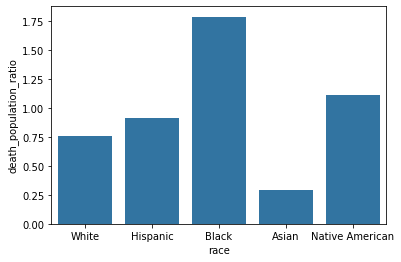

In [54]:
sns.barplot(data = df_race, y = 'death_population_ratio', x = 'race', color = base_color);
# plt.title('proportion of deaths relative to proportion of general population', size = 15);

The barchart above shows that when population is accounted for, black people are being killed at the highest rate, followed by native americans. Asians are being killed at the lowest rate.

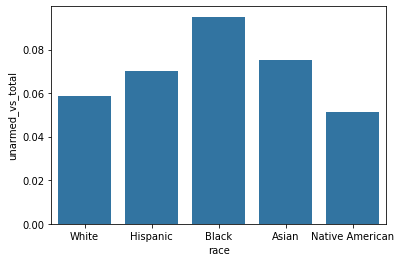

In [55]:
sns.barplot(data = df_race, y = 'unarmed_vs_total', x = 'race', color = base_color);
# plt.title('Proportion of deaths where the deceased was unarmed');

The chart above shows that the Black population are the least likely to be armed when they are killed. Although, this is still only around 9%, when compared to about 8% for Asians and 7% for Hispanics

In [56]:
df.query('race == "White" and year == 2019 and armed == "unarmed"').shape[0]

25

In [57]:
df.query('race == "White" and year == 2019').shape[0]

405

In [58]:
25/405

0.06172839506172839

In [59]:
df.query('race == "Black" and year == 2019 and armed == "unarmed"').shape[0]

14

## Killings by Gender

In [60]:
df.gender.value_counts()

M    5168
F     237
Name: gender, dtype: int64

In [61]:
5168/237

21.80590717299578

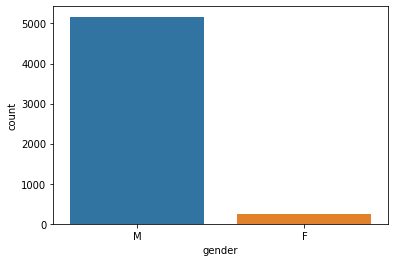

In [62]:
sns.countplot(data = df, x = 'gender');
# plt.title('Number of males and females killed by police between 2015 and June 2020')


The difference in the rate at which males are being killed is staggering. Since 2015 there have been 5168 killings of males and only 237 killings of females. 

## Statisitcal observations

### Can we predict whether a suspect is mentally ill based on race, gender and whether they were fleeing the scene?

In [63]:
df_dum['intercept'] = 1

lm = sm.OLS(df_dum['mentally_ill'], df_dum[['intercept', 'Male', 'Black', 'Hispanic', 'White', 'Asian', 'Native American', 'Fleeing']])
results = lm.fit()
            
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           mentally_ill   R-squared:                       0.065
Model:                            OLS   Adj. R-squared:                  0.064
Method:                 Least Squares   F-statistic:                     53.94
Date:                Sat, 13 Jun 2020   Prob (F-statistic):           7.17e-75
Time:                        18:57:18   Log-Likelihood:                -2768.3
No. Observations:                5407   AIC:                             5553.
Df Residuals:                    5399   BIC:                             5605.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
intercept           0.3390      0.031     10.929      0.000       0.278       0.400
Male               -0.0600      0.027     -2.240      0.025      -0.112      -0.007
Black              -0.0623      0.020     -3.064      0.002      -0.102      -0.022
Hispanic           -0.0339      0.022     -1.569      0.117      -0.076       0.008
White               0.0647      0.019      3.446      0.001       0.028       0.101
Asian               0.0183      0.045      0.406      0.685      -0.070       0.107
Native American    -0.0330      0.049     -0.677      0.498      -0.129       0.063
Fleeing            -0.1770      0.011    -15.471      0.000      -0.199      -0.155
==============================================================================
Omnibus:                      831.469   Durbin-Watson:                   1.969
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1247.001
Skew:                           1.167   Prob(JB):                    1.65e-271
Kurtosis:                       2.704   Cond. No.                         15.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The R-squared value is very low which suggests little reliance can be placed on these findings and it may be hard to cast a prediction. This is unsurprising as the mental health data is binary and so there is a lot of room for error. If we had continuous data such as mental health scores we may be able to identidy a stronger trend. 

The baseline for the analysis is above, represented by the intercept is Race: Other, Gender: female, Fleeing: no.



Below, I have used logisitc regression to see if we can extract more meaningful information.

In [64]:
logm = sm.Logit(df_dum['mentally_ill'], df_dum[['intercept', 'Male', 'Black', 'Hispanic', 'White', 'Asian', 'Native American', 'Fleeing']])
results = logm.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 290.517016
         Iterations 6


C:\Users\willo\anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\willo\anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\willo\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:3409: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.llf/self.llnull


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           mentally_ill   No. Observations:                 5407
Model:                          Logit   Df Residuals:                     5399
Method:                           MLE   Df Model:                            7
Date:                Sat, 13 Jun 2020   Pseudo R-squ.:                     inf
Time:                        18:57:18   Log-Likelihood:            -1.5708e+06
converged:                       True   LL-Null:                        0.0000
Covariance Type:            nonrobust   LLR p-value:                     1.000
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
intercept          -0.6225      0.178     -3.506      0.000      -0.970      -0.275
Male               -0.3297      0.150     -2.201      0.028      -0.623      -0.036
Black              -0.4591      0.131     -3.494      0.000      -0.717      -0.202
Hispanic           -0.2309      0.137     -1.687      0.092      -0.499       0.037
White               0.3571      0.113      3.159      0.002       0.136       0.579
Asian               0.0996      0.263      0.379      0.704      -0.415       0.614
Native American    -0.2224      0.319     -0.698      0.485      -0.847       0.402
Fleeing            -1.2083      0.082    -14.680      0.000      -1.370      -1.047
===================================================================================
"""

In [65]:
1/np.exp(-1.2083), 1/np.exp(-0.4591), np.exp(0.357)

(3.3477885716802347, 1.582648959765529, 1.429035869853877)

In [66]:
# test the accuracy and precision of the model

y = df_dum['mentally_ill']
x = df_dum [['intercept', 'Male', 'Black', 'Hispanic', 'White', 'Asian', 'Native American', 'Fleeing']]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.4, random_state = 0 )

In [67]:
log_mod = LogisticRegression()
log_mod.fit(x_train, y_train)
preds = log_mod.predict(x_test)
print(confusion_matrix(y_test, preds))
print(accuracy_score(y_test, preds))
print(recall_score(y_test, preds))
print(precision_score(y_test, preds))


[[1674    0]
 [ 489    0]]
0.7739251040221914
0.0
0.0


C:\Users\willo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [68]:
482/1681, df_dum.mentally_ill.sum()/df_dum.shape[0]

(0.2867340868530637, 0.22507860181246533)

From the above anlaysis we can see that there were 1681 instnaces where the deceased was correctly predicted to not be mentally ill. There were 482 instances where the model made the same prediction incorrectly. The model never predicted cases of mental illness.

With a recall score of 77.8% and nil recall and precision, we can conclude that using these variables the model is unable to predict whether or not an individual is going to be mentally ill. 

### Police killings by year

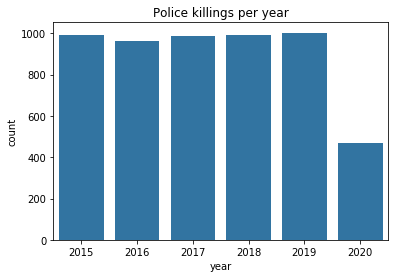

In [69]:
base_color = sns.color_palette()[0]
sns.countplot(data = df, x = 'year', color = base_color)
plt.title('Police killings per year');

At the time of writing this report, we are only half way through 2020, hence the unusually low number. We can clearly see from thi chart that the number of police killings do not appear to be changing year on year. 